# Imports

In [30]:
import torch
import time
import numpy as np
from torch import nn
from math import pi
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, IntSlider, FloatSlider, fixed
from ipywidgets import HBox, interactive_output, ToggleButton, Layout

# Gradient Descent & AutoGrad

Gradient Descent is an iterative algorithm for minimizing the function $f$, starting with an initial value for variables $\mathbf{w}$, taking steps of size $\eta$ (learning rate) in the direction of the negative gradient at the current point to update the variables $\mathbf{w}$.

\begin{equation}
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta \nabla f (\mathbf{w}^{(t)})
\end{equation}

where $\eta > 0$ and $\nabla f (\mathbf{w})= \left( \frac{\partial f(\mathbf{w})}{\partial w_1}, ..., \frac{\partial f(\mathbf{w})}{\partial w_d} \right)$. Since negative gradients always point locally in the direction of steepest descent, the algorithm makes small steps at each point **towards** the minimum.

## Computational Graphs

Take this equation for example:

\begin{equation}
f(x, y, z) = \tanh \left(\ln \left[1 + z \frac{2x}{sin(y)} \right] \right)
\end{equation}

We can build a computational graph to break the original function into smaller and more approachable expressions.

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/comput_graph.png" alt="Computation Graph" width="700"/></center>

Starting from $x$, $y$, and $z$ and following the arrows and expressions, you would see that our graph returns the same function as $f$. It does so by calculating intermediate variables $a,b,c,d,$ and $e$. This is called the **forward pass**.

Now, let’s start from $f$, and work our way against the arrows while calculating the gradient of each expression as we go. This is called the **backward pass**, from which the **backpropagation of errors** algorithm gets its name.

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/comput_graph_full.png" alt="Computation Graph full" width="1200"/></center>

By breaking the computation into simple operations on intermediate variables, we can use the chain rule to calculate any gradient:

\begin{equation}
\dfrac{\partial f}{\partial x} = \dfrac{\partial f}{\partial e}~\dfrac{\partial e}{\partial d}~\dfrac{\partial d}{\partial c}~\dfrac{\partial c}{\partial a}~\dfrac{\partial a}{\partial x} = \left( 1-\tanh^2(e) \right) \cdot \frac{1}{d+1}\cdot z \cdot \frac{1}{b} \cdot 2
\end{equation}

Conveniently, the values for $e$, $b$, and $d$ are available to us from when we did the forward pass through the graph. That is, the partial derivatives have simple expressions in terms of the intermediate variables $a,b,c,d,e$ that we calculated and stored during the forward pass.


## PyTorch AutoGrad

In PyTorch, to indicate that a certain tensor contains learnable parameters, we can set the optional argument `requires_grad` to `True`. PyTorch will then track every operation using this tensor while configuring the computational graph. For this exercise, use the provided tensors to build the following graph, which implements a single neuron with scalar input and output.

<br/>

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/simple_graph.png" alt="Simple nn graph" width="600"/></center>

In [ ]:
class SimpleGraph:
    def __init__(self, w, b):
        """Initializing the SimpleGraph

        Args:
          w (float): initial value for weight
          b (float): initial value for bias
        """
        assert isinstance(w, float)
        assert isinstance(b, float)
        self.w = torch.tensor([w], requires_grad=True)
        self.b = torch.tensor([b], requires_grad=True)

    def forward(self, x):
        """Forward pass

        Args:
          x (torch.Tensor): 1D tensor of features

        Returns:
          torch.Tensor: model predictions
        """
        assert isinstance(x, torch.Tensor)
        prediction = torch.tanh(x * self.w + self.b)
        return prediction


def sq_loss(y_true, y_prediction):
    """L2 loss function

    Args:
    y_true (torch.Tensor): 1D tensor of target labels
    y_prediction (torch.Tensor): 1D tensor of predictions

    Returns:
    torch.Tensor: L2-loss (squared error)
    """
    assert isinstance(y_true, torch.Tensor)
    assert isinstance(y_prediction, torch.Tensor)
    loss = (y_true - y_prediction)**2
    return loss


feature = torch.tensor([1])  # input tensor
target = torch.tensor([7])  # target tensor

# run graph
simple_graph = SimpleGraph(-0.5, 0.5)
print(f"initial weight = {simple_graph.w.item()}, "
      f"\ninitial bias = {simple_graph.b.item()}")
prediction = simple_graph.forward(feature)
square_loss = sq_loss(target, prediction)
print(f"for x={feature.item()} and y={target.item()}, "
      f"prediction={prediction.item()}, and L2 Loss = {square_loss.item()}")

## Pytorch Neural Net Module

PyTorch provides us with ready-to-use neural network building blocks, such as layers (e.g. linear, recurrent, ...), different activation and loss functions, and much more, packed in the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) module. If we build a neural network using `torch.nn` layers, the weights and biases are already in `requires_grad` mode and will be registered as model parameters. 

For training, we need three things:

*   **Model parameters** - Model parameters refer to all the learnable parameters of the model, which are accessible by calling `.parameters()` on the model. Please note that NOT all the `requires_grad` tensors are seen as model parameters. To create a custom model parameter, we can use [`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) (*A kind of Tensor that is to be considered a module parameter*).

*   **Loss function** - The loss that we are going to be optimizing, which is often combined with regularization terms.

*   **Optimizer** - PyTorch provides us with many optimization methods (different versions of gradient descent). Optimizer holds the current state of the model and by calling the `step()` method, will update the parameters based on the computed gradients.

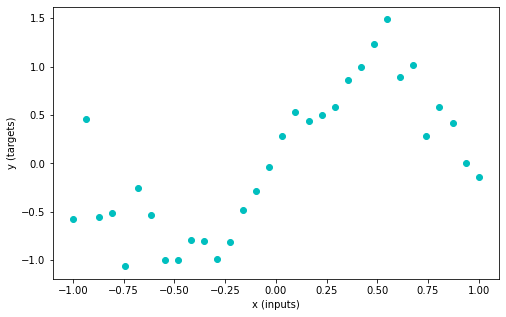

In [11]:
# generate sample dataset
n_samples = 32
inputs = torch.linspace(-1.0, 1.0, n_samples).reshape(n_samples, 1)
noise = torch.randn(n_samples, 1) / 4
targets = torch.sin(pi * inputs) + noise
plt.figure(figsize=(8, 5))
plt.scatter(inputs, targets, c='c')
plt.xlabel('x (inputs)')
plt.ylabel('y (targets)')
plt.show()

In [12]:
## A Wide neural network with a single hidden layer
class WideNet(nn.Module):

    def __init__(self):
        """Initializing the WideNet
        """
        n_cells = 512
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, n_cells),
            nn.Tanh(),
            nn.Linear(n_cells, 1),
        )

    def forward(self, x):
        """Forward pass

        Args:
          x (torch.Tensor): 2D tensor of features

        Returns:
          torch.Tensor: model predictions
        """
        return self.layers(x)

In [18]:
# helper function for plotting
def ex3_plot(model, x, y, ep, lss):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.set_title("Regression")
    ax1.plot(x, model(x).detach().numpy(), color='r', label='prediction')
    ax1.scatter(x, y, c='c', label='targets')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.legend()

    ax2.set_title("Training loss")
    ax2.plot(np.linspace(1, epochs, epochs), losses, color='y')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("MSE")

    plt.show()

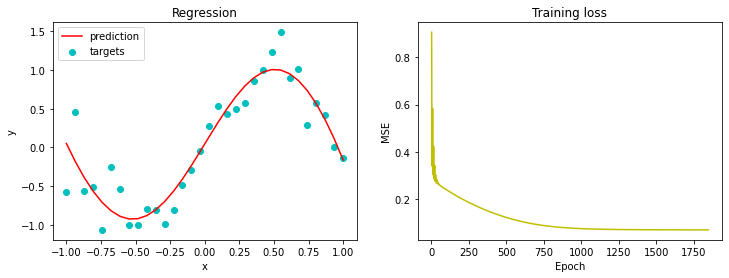

In [16]:
def train(features, labels, model, loss_fun, optimizer, n_epochs):
    """Training function

    Args:
    features (torch.Tensor): features (input) with shape torch.Size([n_samples, 1])
    labels (torch.Tensor): labels (targets) with shape torch.Size([n_samples, 1])
    model (torch nn.Module): the neural network
    loss_fun (function): loss function
    optimizer(function): optimizer
    n_epochs (int): number of training iterations

    Returns:
    list: record (evolution) of training losses
    """
    loss_record = []  # keeping recods of loss

    for i in range(n_epochs):
        optimizer.zero_grad()  # set gradients to 0
        predictions = model(features)  # Compute model prediction (output)
        loss = loss_fun(predictions, labels)  # Compute the loss
        loss.backward()  # Compute gradients (backward pass)
        optimizer.step()  # update parameters (optimizer takes a step)

        loss_record.append(loss.item())
    return loss_record

# Create an instance of the neural net
wide_net = WideNet()
# Create a mse loss function
loss_function = nn.MSELoss()
# Stochastic Gradient Descent optimizer
lr = 0.003  # learning rate
sgd_optimizer = torch.optim.SGD(wide_net.parameters(), lr=lr, momentum=0.9)
epochs = 1847 # Cauchy, Exercices d'analyse et de physique mathematique (1847)
losses = train(inputs, targets, wide_net, loss_function, sgd_optimizer, epochs)
ex3_plot(wide_net, inputs, targets, epochs, losses)

# Learning Hyperparameters

## Simple narrow linear neural network

To better understand the behavior of neural network training with gradient descent, we start with the incredibly simple case of a shallow narrow linear neural net, since state-of-the-art models are impossible to dissect and comprehend with our current mathematical tools.

The model we use has one hidden layer, with only one neuron, and two weights. We consider the squared error (or L2 loss) as the cost function. As you may have already guessed, we can visualize the model as a neural network:

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/shallow_narrow_nn.png" width="400"/></center>

<br/>

or by its computation graph:

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/shallow_narrow.png" alt="Shallow Narrow Graph" width="400"/></center>

In [19]:
# helper plotting function
def plot_x_y_(x_t_, y_t_, x_ev_, y_ev_, loss_log_, weight_log_):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.scatter(x_t_, y_t_, c='r', label='training data')
    plt.plot(x_ev_, y_ev_, c='b', label='test results', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(loss_log_, c='r')
    plt.xlabel('epochs')
    plt.ylabel('mean squared error')
    plt.subplot(1, 3, 3)
    plt.plot(weight_log_)
    plt.xlabel('epochs')
    plt.ylabel('weights')
    plt.show()

In [ ]:
class ShallowNarrowExercise:
    """Shallow and narrow (one neuron per layer) linear neural network
    """
    def __init__(self, init_weights):
        """
        Args:
          init_weights (list): initial weights
        """
        assert isinstance(init_weights, (list, np.ndarray, tuple))
        assert len(init_weights) == 2
        self.w1 = init_weights[0]
        self.w2 = init_weights[1]


    def forward(self, x):
        """The forward pass through netwrok y = x * w1 * w2

        Args:
          x (np.ndarray): features (inputs) to neural net

        returns:
          (np.ndarray): neural network output (prediction)
        """
        y = x * self.w1 * self.w2
        return y


    def dloss_dw(self, x, y_true):
        """Gradient of loss with respect to weights

        Args:
          x (np.ndarray): features (inputs) to neural net
          y_true (np.ndarray): true labels

        returns:
          (float): mean gradient of loss with respect to w1
          (float): mean gradient of loss with respect to w2
        """
        assert x.shape == y_true.shape
        dloss_dw1 = - (2 * self.w2 * x * (y_true - self.w1 * self.w2 * x)).mean()
        dloss_dw2 = - (2 * self.w1 * x * (y_true - self.w1 * self.w2 * x)).mean()
        return dloss_dw1, dloss_dw2


    def train(self, x, y_true, lr, n_ep):
        """Training with Gradient descent algorithm

        Args:
          x (np.ndarray): features (inputs) to neural net
          y_true (np.ndarray): true labels
          lr (float): learning rate
          n_ep (int): number of epochs (training iterations)

        returns:
          (list): training loss records
          (list): training weight records (evolution of weights)
        """
        assert x.shape == y_true.shape

        loss_records = np.empty(n_ep)  # pre allocation of loss records
        weight_records = np.empty((n_ep, 2))  # pre allocation of weight records

        for i in range(n_ep):
            y_prediction = self.forward(x)
            loss_records[i] = loss(y_prediction, y_true)
            dloss_dw1, dloss_dw2 = self.dloss_dw(x, y_true)
            self.w1 -= lr * dloss_dw1
            self.w2 -= lr * dloss_dw2
            weight_records[i] = [self.w1, self.w2]

        return loss_records, weight_records


def loss(y_prediction, y_true):
    """Mean squared error

    Args:
    y_prediction (np.ndarray): model output (prediction)
    y_true (np.ndarray): true label

    returns:
    (np.ndarray): mean squared error loss
    """
    assert y_prediction.shape == y_true.shape
    mse = ((y_true - y_prediction)**2).mean()
    return mse

n_epochs = 211
learning_rate = 0.02
initial_weights = [1.4, -1.6]
x_train, y_train = gen_samples(n=73, a=2.0, sigma=0.2)
x_eval = np.linspace(0.0, 1.0, 37, endpoint=True)
sn_model = ShallowNarrowExercise(initial_weights)
loss_log, weight_log = sn_model.train(x_train, y_train, learning_rate, n_epochs)
y_eval = sn_model.forward(x_eval)
plot_x_y_(x_train, y_train, x_eval, y_eval, loss_log, weight_log)

## Depth, learning rate, and initialization

### helper plotting functions

In [33]:
def gen_samples(n, a, sigma):
    """
    Generates `n` samples with `y = z * x + noise(sgma)` linear relation.

    Args:
    n : int
    a : float
    sigma : float
    Retutns:
    x : np.array
    y : np.array
    """
    assert n > 0
    assert sigma >= 0

    if sigma > 0:
        x = np.random.rand(n)
        noise = np.random.normal(scale=sigma, size=(n))
        y = a * x + noise
    else:
        x = np.linspace(0.0, 1.0, n, endpoint=True)
        y = a * x
    return x, y

class ShallowNarrowLNN:
    """
    Shallow and narrow (one neuron per layer) linear neural network
    """
    def __init__(self, init_ws):
        """
        init_ws: initial weights as a list
        """
        assert isinstance(init_ws, list)
        assert len(init_ws) == 2
        self.w1 = init_ws[0]
        self.w2 = init_ws[1]

    def forward(self, x):
        """
        The forward pass through netwrok y = x * w1 * w2
        """
        y = x * self.w1 * self.w2
        return y

    def loss(self, y_p, y_t):
        """
        Mean squared error (L2) with 1/2 for convenience
        """
        assert y_p.shape == y_t.shape
        mse = ((y_t - y_p)**2).mean()
        return mse

    def dloss_dw(self, x, y_t):
        """
        partial derivative of loss with respect to weights

        Args:
          x : np.array
          y_t : np.array
        """
        assert x.shape == y_t.shape
        Error = y_t - self.w1 * self.w2 * x
        dloss_dw1 = - (2 * self.w2 * x * Error).mean()
        dloss_dw2 = - (2 * self.w1 * x * Error).mean()
        return dloss_dw1, dloss_dw2

    def train(self, x, y_t, eta, n_ep):
        """
        Gradient descent algorithm

        Args:
          x : np.array
          y_t : np.array
          eta: float
          n_ep : int
        """
        assert x.shape == y_t.shape

        loss_records = np.empty(n_ep)  # pre allocation of loss records
        weight_records = np.empty((n_ep, 2))  # pre allocation of weight records

        for i in range(n_ep):
            y_p = self.forward(x)
            loss_records[i] = self.loss(y_p, y_t)
            dloss_dw1, dloss_dw2 = self.dloss_dw(x, y_t)
            self.w1 -= eta * dloss_dw1
            self.w2 -= eta * dloss_dw2
            weight_records[i] = [self.w1, self.w2]

        return loss_records, weight_records


class DeepNarrowLNN:
    """
    Deep but thin (one neuron per layer) linear neural network
    """
    def __init__(self, init_ws):
        """
        init_ws: initial weights as a numpy array
        """
        self.n = init_ws.size
        self.W = init_ws.reshape(1, -1)

    def forward(self, x):
        """
        x : np.array
          input features
        """
        y = np.prod(self.W) * x
        return y

    def loss(self, y_t, y_p):
        """
        mean squared error (L2 loss)

        Args:
          y_t : np.array
          y_p : np.array
        """
        assert y_p.shape == y_t.shape
        mse = ((y_t - y_p)**2 / 2).mean()
        return mse

    def dloss_dw(self, x, y_t, y_p):
        """
        analytical gradient of weights

        Args:
          x : np.array
          y_t : np.array
          y_p : np.array
        """
        E = y_t - y_p  # = y_t - x * np.prod(self.W)
        Ex = np.multiply(x, E).mean()
        Wp = np.prod(self.W) / (self.W + 1e-9)
        dW = - Ex * Wp
        return dW

    def train(self, x, y_t, eta, n_epochs):
        """
        training using gradient descent

        Args:
          x : np.array
          y_t : np.array
          eta: float
          n_epochs : int
        """
        loss_records = np.empty(n_epochs)
        loss_records[:] = np.nan
        for i in range(n_epochs):
            y_p = self.forward(x)
            loss_records[i] = self.loss(y_t, y_p).mean()
            dloss_dw = self.dloss_dw(x, y_t, y_p)
            if np.isnan(dloss_dw).any() or np.isinf(dloss_dw).any():
                return loss_records
            self.W -= eta * dloss_dw
        return loss_records

def lr_widget(lr):
    depth_lr_init_interplay(50, lr, 0.9)

def depth_lr_interplay(depth, lr):
    depth_lr_init_interplay(depth, lr, 0.9)

def depth_lr_init_interplay(depth, lr, init_weights):
    n_epochs = 600

    x_train, y_train = gen_samples(100, 2.0, 0.1)
    model = DeepNarrowLNN(np.full((1, depth+1), init_weights))

    plt.figure(figsize=(10, 5))
    plt.plot(model.train(x_train, y_train, lr, n_epochs),
            linewidth=3.0, c='m')

    plt.title("Training a {}-layer LNN with"
    " $\eta=${} initialized with $w_i=${}".format(depth, lr, init_weights), pad=15)
    plt.yscale('log')
    plt.xlabel('epochs')
    plt.ylabel('Log mean squared error')
    plt.ylim(0.001, 1.0)
    plt.show()
    
def plot_init_effect():
    depth = 15
    n_epochs = 250
    lr = 0.02

    x_train, y_train = gen_samples(100, 2.0, 0.1)

    plt.figure(figsize=(12, 6))
    for init_w in np.arange(0.7, 1.09, 0.05):
      model = DeepNarrowLNN(np.full((1, depth), init_w))
      plt.plot(model.train(x_train, y_train, lr, n_epochs),
              linewidth=3.0, label="initial weights {:.2f}".format(init_w))
    plt.title("Training a {}-layer narrow LNN with $\eta=${}".format(depth, lr), pad=15)
    plt.yscale('log')
    plt.xlabel('epochs')
    plt.ylabel('Log mean squared error')
    plt.legend(loc='lower left', ncol=4)
    plt.ylim(0.001, 1.0)
    plt.show()

def depth_widget(depth):
    if depth == 0:
        depth_lr_init_interplay(depth, 0.02, 0.9)
    else:
        depth_lr_init_interplay(depth, 0.01, 0.9)
        
class InterPlay:
    def __init__(self):
        self.lr = [None]
        self.depth = [None]
        self.success = [None]
        self.min_depth, self.max_depth = 5, 65
        self.depth_list = np.arange(10, 61, 10)
        self.i_depth = 0
        self.min_lr, self.max_lr = 0.001, 0.105
        self.n_epochs = 600
        self.x_train, self.y_train = gen_samples(100, 2.0, 0.1)
        self.converged = False
        self.button = None
        self.slider = None

    def train(self, lr, update=False, init_weights=0.9):
        if update and self.converged and self.i_depth < len(self.depth_list):
            depth = self.depth_list[self.i_depth]
            self.plot(depth, lr)
            self.i_depth += 1
            self.lr.append(None)
            self.depth.append(None)
            self.success.append(None)
            self.converged = False
            self.slider.value = 0.005
            if self.i_depth < len(self.depth_list):
                self.button.value = False
                self.button.description = 'Explore!'
                self.button.disabled = True
                self.button.button_style = 'danger'
            else:
                self.button.value = False
                self.button.button_style = ''
                self.button.disabled = True
                self.button.description = 'Done!'
            time.sleep(1.0)
        elif self.i_depth < len(self.depth_list):
            depth = self.depth_list[self.i_depth]
            # assert self.min_depth <= depth <= self.max_depth
            assert self.min_lr <= lr <= self.max_lr
            self.converged = False

            model = DeepNarrowLNN(np.full((1, depth), init_weights))
            self.losses = np.array(model.train(self.x_train, self.y_train, lr, self.n_epochs))
            if np.any(self.losses < 1e-2):
                success = np.argwhere(self.losses < 1e-2)[0][0]
                if np.all((self.losses[success:] < 1e-2)):
                    self.converged = True
                    self.success[-1] = success
                    self.lr[-1] = lr
                    self.depth[-1] = depth
                    self.button.disabled = False
                    self.button.button_style = 'success'
                    self.button.description = 'Register!'
                else:
                    self.button.disabled = True
                    self.button.button_style = 'danger'
                    self.button.description = 'Explore!'
            else:
                self.button.disabled = True
                self.button.button_style = 'danger'
                self.button.description = 'Explore!'
            self.plot(depth, lr)

    def plot(self, depth, lr):
        fig = plt.figure(constrained_layout=False, figsize=(10, 8))
        gs = fig.add_gridspec(2, 2)
        ax1 = fig.add_subplot(gs[0, :])
        ax2 = fig.add_subplot(gs[1, 0])
        ax3 = fig.add_subplot(gs[1, 1])

        ax1.plot(self.losses, linewidth=3.0, c='m')
        ax1.set_title("Training a {}-layer LNN with"
        " $\eta=${}".format(depth, lr), pad=15, fontsize=16)
        ax1.set_yscale('log')
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('Log mean squared error')
        ax1.set_ylim(0.001, 1.0)

        ax2.set_xlim(self.min_depth, self.max_depth)
        ax2.set_ylim(-10, self.n_epochs)
        ax2.set_xlabel('Depth')
        ax2.set_ylabel('Learning time (Epochs)')
        ax2.set_title("Learning time vs depth", fontsize=14)
        ax2.scatter(np.array(self.depth), np.array(self.success), c='r')

        # ax3.set_yscale('log')
        ax3.set_xlim(self.min_depth, self.max_depth)
        ax3.set_ylim(self.min_lr, self.max_lr)
        ax3.set_xlabel('Depth')
        ax3.set_ylabel('Optimial learning rate')
        ax3.set_title("Empirically optimal $\eta$ vs depth", fontsize=14)
        ax3.scatter(np.array(self.depth), np.array(self.lr), c='r')

        plt.show()

### Depth

Let's look at the challenges that depth poses in training a neural network. Imagine a single input, single output linear network with 50 hidden layers and only one neuron per layer (i.e. a narrow deep neural network). The output of the network is easy to calculate:

$$ prediction = x \cdot w_1 \cdot w_2 \cdot \cdot \cdot w_{50} $$

If the initial value for all the weights is $w_i = 2$, the prediction for $x=1$ would be **exploding**: $y_p = 2^{50} \approx 1.1256 \times 10^{15}$. On the other hand, for weights initialized to $w_i = 0.5$, the output is **vanishing**: $y_p = 0.5^{50} \approx 8.88 \times 10^{-16}$. Similarly, if we recall the chain rule, as the graph gets deeper, the number of elements in the chain multiplication increases, which could lead to exploding or vanishing gradients. To avoid such numerical vulnerablities that could impair our training algorithm, we need to understand the effect of depth.


In [25]:
_ = interact(depth_widget,
    depth = IntSlider(min=0, max=51,
                      step=5, value=0,
                      continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='depth', max=51, step=5), Output…

### Learning rate

In [26]:
_ = interact(lr_widget,
    lr = FloatSlider(min=0.005, max=0.045, step=0.005, value=0.005,
                     continuous_update=False, readout_format='.3f',
                     description='eta'))

interactive(children=(FloatSlider(value=0.005, continuous_update=False, description='eta', max=0.045, min=0.00…

### Depth vs. learning rate

In [34]:
intpl_obj = InterPlay()

intpl_obj.slider = FloatSlider(min=0.005, max=0.105, step=0.005, value=0.005,
                               layout=Layout(width='500px'),
                               continuous_update=False,
                               readout_format='.3f',
                               description='eta')

intpl_obj.button = ToggleButton(value=intpl_obj.converged, description='Register')

widgets_ui = HBox([intpl_obj.slider, intpl_obj.button])
widgets_out = interactive_output(intpl_obj.train,
                                 {'lr': intpl_obj.slider,
                                  'update': intpl_obj.button,
                                  'init_weights': fixed(0.9)})

display(widgets_ui, widgets_out)

Output()

### Initialization

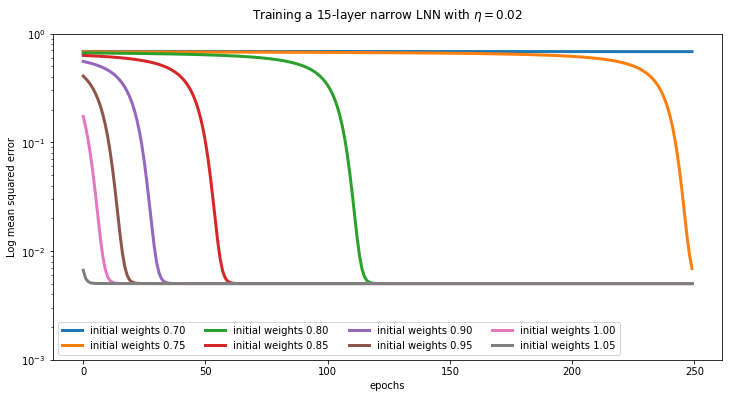

In [35]:
plot_init_effect()